I construct a MCMC to predict the probabilities of having a sunny/cluody day after N days. In the first part I analyze the probabilities p(sunny) and p(cloudy) and the traceplots given by MCMC. In the second part I discard the first values of the chain (burn-in).

The probabilities that I need to construct the MCMC are:
- $p({\rm clear \; tomorrow} \, |\,  {\rm cloudy \; today}) = 0.5$,
- $p({\rm cloudy \; tomorrow} \, |\, {\rm cloudy \; today}) = 0.5$,
- $p({\rm cloudy \; tomorrow} \, |\, {\rm clear \; today}) = 0.1$,
- $p({\rm clear \; tomorrow} \, |\, {\rm clear \; today}) = 0.9$.

In [25]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os

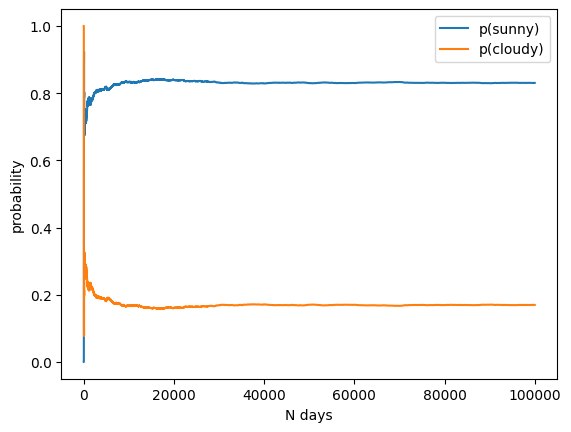

Probability of sunny day = 0.830412
Probability of cloudy day = 0.169588


In [26]:
# I define the probabilities
p_s_c = 0.5
p_c_c = 0.5
p_c_s = 0.1
p_s_s = 0.9

# I start with a cloudy day. 0 cloudy day, 1 sunny day
x_i = 0
N= 10**5
array_x = []
array_x.append(x_i)   # array in which I will save the 0 and 1 days

for i in range (0, N):
   # proposed value: random number between 0 and 1
   x_f = np.random.randint(0, 2)

   # I define the probability of tomorrow|today
   if x_i==0 and x_f==0:
      p = p_c_c
   elif x_i==0 and x_f==1:
      p = p_s_c
   elif x_i==1 and x_f==0:
      p = p_c_s
   elif x_i==1 and x_f==1:
      p = p_s_s

   # acceptance criterion to decide if the proposed value can be added to the chain
   acceptance = np.random.uniform(0, 1)
   if p>acceptance:   # if the new value is accepted...
      x_i = x_f

   array_x.append(x_i)

# every day I save the counts of n° total days, n° sunny days/total days, n° cloudy days/total days
array_days = np.zeros(len(array_x))
sunny_days = np.zeros(len(array_x))
cloudy_days = np.zeros(len(array_x))
s_count = 0
c_count = 0
for i in range (0, len(array_x)):
   array_days[i] = i+1          # total days

   if array_x[i] == 0:
      c_count = c_count + 1     # cloudy days
   elif array_x[i] == 1:
      s_count = s_count + 1     # sunny days

   sunny_days[i] = s_count/(i+1)
   cloudy_days[i] = c_count/(i+1)

plt.plot(array_days, sunny_days, label='p(sunny)')
plt.plot(array_days, cloudy_days, label='p(cloudy)')
plt.xlabel('N days')
plt.ylabel('probability')
plt.legend()
plt.show()

print('Probability of sunny day = %f' %sunny_days[-1])
print('Probability of cloudy day = %f' %cloudy_days[-1])

Text(0.5, 0, 'p(sunny_day)')

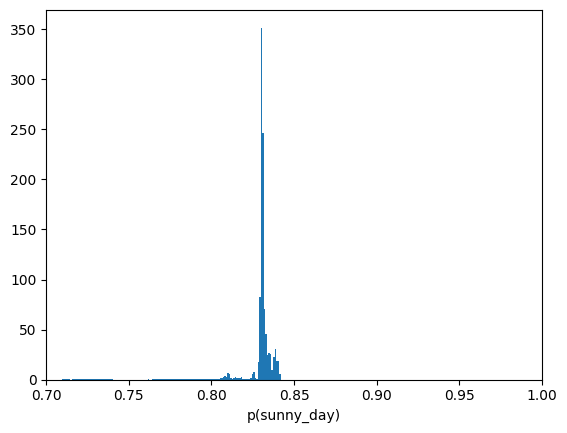

In [27]:
plt.hist(sunny_days, bins=1000, density=True)
plt.xlim(0.7, 1.0)
plt.xlabel('p(sunny_day)')

Since the first values of the chain don't follow the posterior distribution (they are strongly dependent on the initial value), I need to discard the first part of the chain. This operation is called burn-in.

In the following part I use 3 different burn-in values to observe how the result changes.

# Burn-in

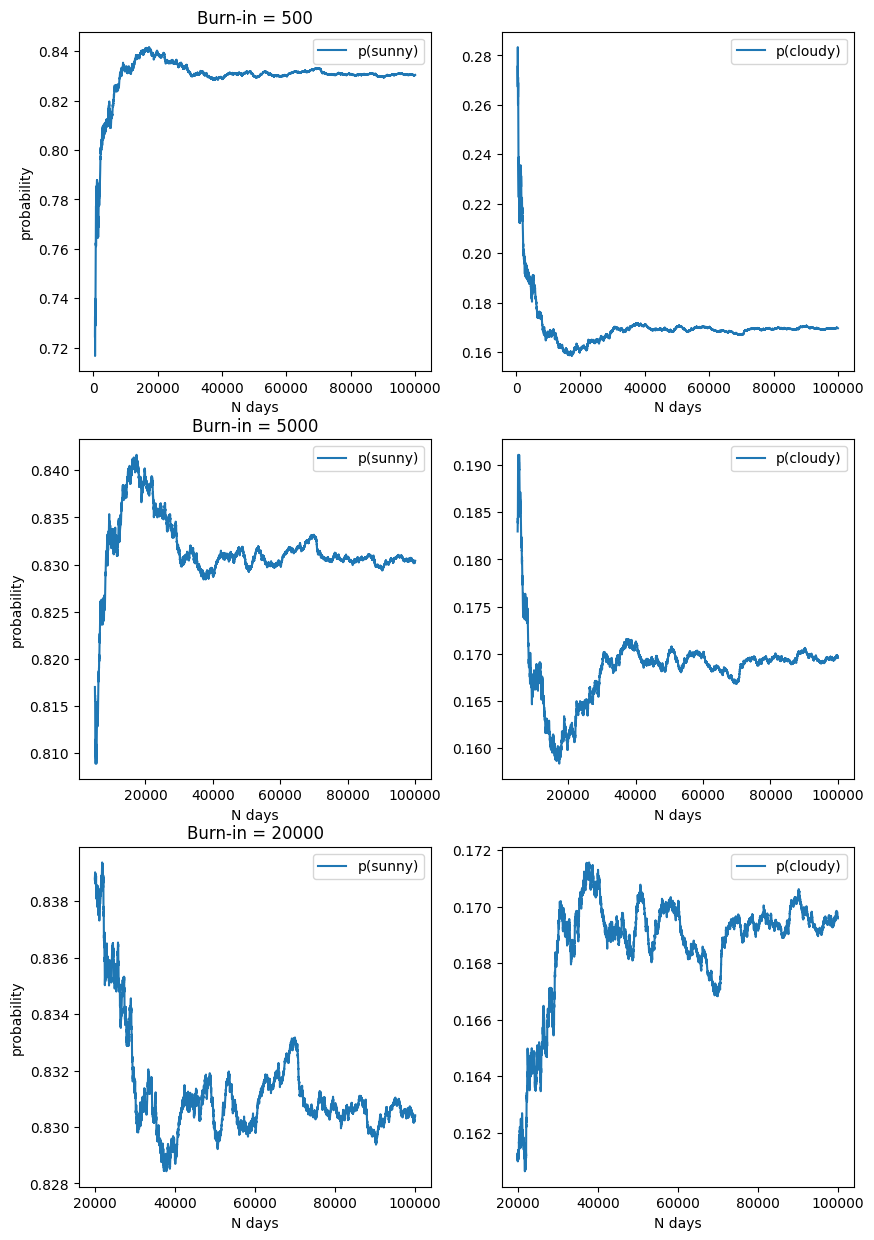

In [28]:
# burn-in phase: I discard the early steps of the chain
# I change the burn-in and I observe how the result evolves
burn_in = [500, 5000, 20000]

fig, ax = plt.subplots(len(burn_in), 2, figsize = (10, 5*len(burn_in)))
i = 0

for burn in burn_in:
   new_array_days = array_days[burn:]
   new_sunny_days = sunny_days[burn:]
   new_cloudy_days = cloudy_days[burn:]
   ax[i, 0].plot(new_array_days, new_sunny_days, label='p(sunny)')
   ax[i, 0].set_xlabel('N days')
   ax[i, 0].set_ylabel('probability')
   ax[i, 0].set_title('Burn-in = %i' %burn)
   ax[i, 0].legend()

   ax[i, 1].plot(new_array_days, new_cloudy_days, label='p(cloudy)')
   ax[i, 1].set_xlabel('N days')
   ax[i, 1].legend()

   i = i+1

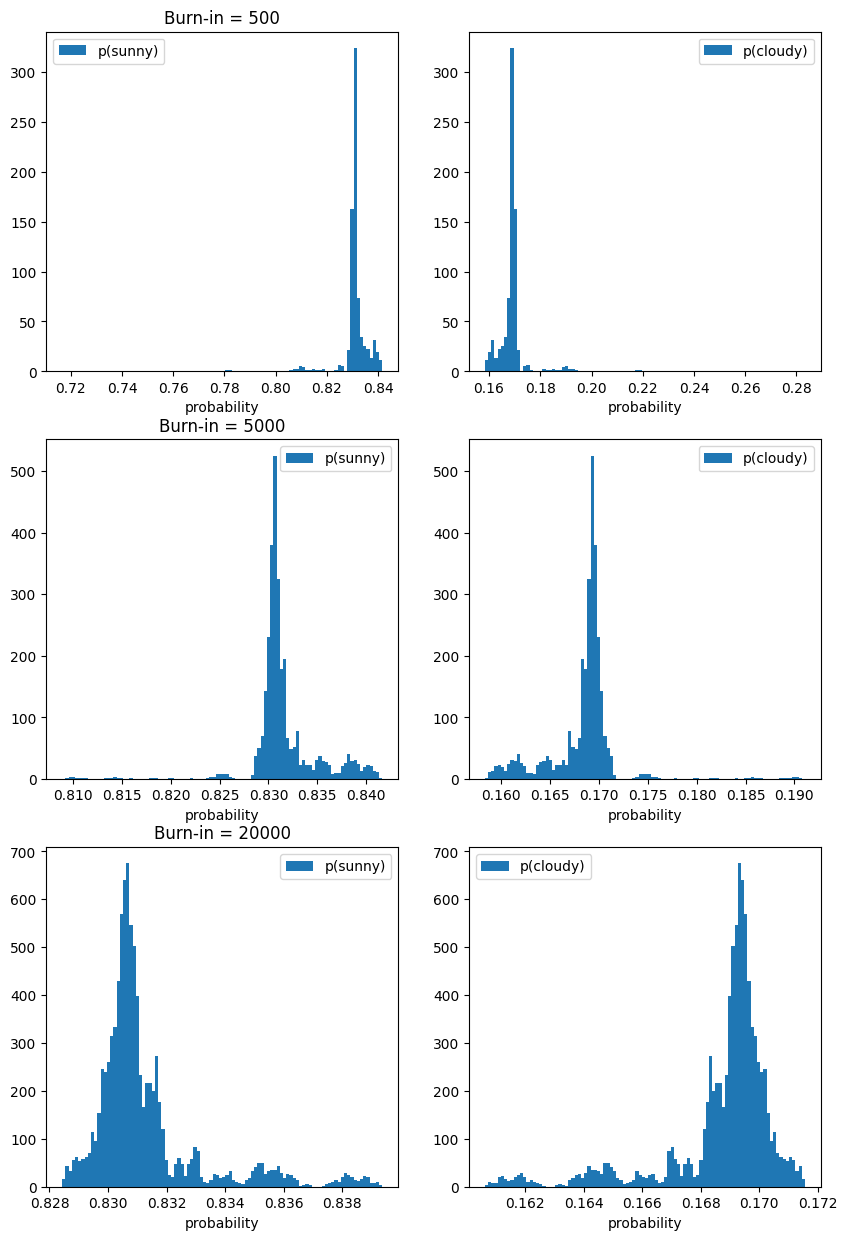

In [29]:
fig, ax = plt.subplots(len(burn_in), 2, figsize = (10, 5*len(burn_in)))
i = 0

for burn in burn_in:
   new_array_days = array_days[burn:]
   new_sunny_days = sunny_days[burn:]
   new_cloudy_days = cloudy_days[burn:]
   ax[i, 0].hist(new_sunny_days, bins=100, label='p(sunny)', density=True)
   ax[i, 0].set_xlabel('probability')
   ax[i, 0].set_title('Burn-in = %i' %burn)
   ax[i, 0].legend()

   ax[i, 1].hist(new_cloudy_days, bins=100, label='p(cloudy)', density=True)
   ax[i, 1].set_xlabel('probability')
   ax[i, 1].legend()

   i = i+1

In [30]:
# statistics for different burn-in

for burn in burn_in:
   new_array_days = array_days[burn:]
   new_sunny_days = sunny_days[burn:]
   new_cloudy_days = cloudy_days[burn:]

   # expected value
   ex_p_s = np.mean(new_sunny_days)
   ex_p_c = np.mean(new_cloudy_days)

   # 68% equal-tailed credible region
   lower_s, upper_s = np.percentile(new_sunny_days,q=16), np.percentile(new_sunny_days,q=84)
   lower_c, upper_c = np.percentile(new_cloudy_days,q=16), np.percentile(new_cloudy_days,q=84)

   # MAP value
   hist, bins = np.histogram(new_sunny_days, bins=50)
   bin_mid = 0.5 * (bins[1:] + bins[:-1])   # I compute the mean between the bin limit values
   idx = np.argsort(hist)[-1]               # array which contains the list of indeces of the elements of hist with increasing order
   map_theta_s = bin_mid[idx]               # I choose the mean value of the bin with the highest number of counts -> MAP

   hist, bins = np.histogram(new_cloudy_days, bins=50)
   bin_mid = 0.5 * (bins[1:] + bins[:-1])
   idx = np.argsort(hist)[-1]
   map_theta_c = bin_mid[idx]

   print('Burn-in = ' + str(burn))
   print('Expected value of p(sunny) = ' + str(ex_p_s))
   print('Expected value of p(cloudy) = ' + str(ex_p_c))
   print('68% credible region of p(sunny) = ' + str(lower_s) + ' to ' + str(upper_s))
   print('68% credible region of p(cloudy) = ' + str(lower_c) + ' to ' + str(upper_c))
   print('MAP value of p(sunny) = ' + str(map_theta_s))
   print('MAP value of p(cloudy) = ' + str(map_theta_c))
   print('-----------------------------------------------')

Burn-in = 500
Expected value of p(sunny) = 0.8299193423953016
Expected value of p(cloudy) = 0.17008065760469832
68% credible region of p(sunny) = 0.8298038505506445 to 0.8338363087663164
68% credible region of p(cloudy) = 0.1661636912336836 to 0.1701961494493554
MAP value of p(sunny) = 0.8303933781362867
MAP value of p(cloudy) = 0.16960662186371334
-----------------------------------------------
Burn-in = 5000
Expected value of p(sunny) = 0.8315827590271766
Expected value of p(cloudy) = 0.16841724097282326
68% credible region of p(sunny) = 0.8299935358758889 to 0.8341499786962079
68% credible region of p(cloudy) = 0.16585002130379206 to 0.1700064641241112
MAP value of p(sunny) = 0.8308421959791812
MAP value of p(cloudy) = 0.1691578040208189
-----------------------------------------------
Burn-in = 20000
Expected value of p(sunny) = 0.8312828379723965
Expected value of p(cloudy) = 0.16871716202760356
68% credible region of p(sunny) = 0.8300341296928327 to 0.8322426855746018
68% credible